# **Nama: Muhammad Amanda**
# **Username: muh_amanda** 
# **Kota: Kota Jakarta Timur, DKI Jakarta**
# *Waktu bergabung pada 12 May 2020*

In [ ]:
# Import library yang dibutuhkan
import zipfile,os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm as tq
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

--2021-04-14 13:40:10--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  1.04MB/s    in 5m 22s  

2021-04-14 13:45:33 (981 KB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



In [3]:
local_zip = '/tmp/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
 
base_dir = '/tmp/rockpaperscissors'
paper_dir = os.path.join(base_dir, 'paper')
rock_dir = os.path.join(base_dir, 'rock')
scissors_dir = os.path.join(base_dir, 'scissors')

# Data Cleaning
Membuang folder maupun file yang tidak dibutuhkan, dalam hal ini folder `rps-cv-images` dan file `README_rpc-cv-images.txt`.

In [4]:
dir_path = '/tmp/rockpaperscissors/rps-cv-images'
try: 
  shutil.rmtree(dir_path)
except OSError as e:
  print("Error: %s: %s" % (dir_path, e.strerror))

file_path = '/tmp/rockpaperscissors/README_rpc-cv-images.txt'
try: 
  os.remove(file_path)
except OSError as e:
  print("Error: %s: %s" % (dir_path, e.strerror))

In [5]:
file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(base_dir):
    for name in files:
        full_path.append(os.path.join(path, name)) 
        tag.append(path.split('/')[-1])        
        file_name.append(name)

In [6]:
df = pd.DataFrame({"path":full_path,'file_name':file_name,"tag":tag})
df.groupby(['tag']).size()

tag
paper       712
rock        726
scissors    750
dtype: int64

In [7]:
df.head()

,path,file_name,tag
0,/tmp/rockpaperscissors/paper/45OQyZuXtfNCc8Rk.png,45OQyZuXtfNCc8Rk.png,paper
1,/tmp/rockpaperscissors/paper/LqxEdPczGbYd9Zlu.png,LqxEdPczGbYd9Zlu.png,paper
2,/tmp/rockpaperscissors/paper/oKx22gb6XjI0aXHR.png,oKx22gb6XjI0aXHR.png,paper
3,/tmp/rockpaperscissors/paper/C9tAvywdtjDTnllg.png,C9tAvywdtjDTnllg.png,paper
4,/tmp/rockpaperscissors/paper/TcybcTuKdMPA4xpT.png,TcybcTuKdMPA4xpT.png,paper


## Membagi Dataset menjadi Data Train dan Data Validation
Data Train sebesar 60% dan Data Validation sebesar 40%

In [8]:
X= df['path']
y= df['tag']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.40, random_state=42)

In [14]:
df_tr = pd.DataFrame({'path':X_train
              ,'tag':y_train
             ,'set':'train'})

df_val = pd.DataFrame({'path':X_val
              ,'tag':y_val
             ,'set':'validation'})
df_all = df_tr.append(df_val).reset_index(drop=1)

In [16]:
datasource_path = '/tmp/rockpaperscissors'
dataset_path = "/tmp/dataset"
for index, row in tq(df_all.iterrows()):

    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['tag'],row['image'].split('.')[0])            

    if os.path.exists(os.path.join(dataset_path,row['set'],row['tag'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['tag']))

    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['tag'],destination_file_name)

    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

In [17]:
train_dir = os.path.join(dataset_path, 'train')
validation_dir = os.path.join(dataset_path, 'validation')

In [54]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    vertical_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')
 
validation_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    vertical_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

In [55]:
train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size=(150, 150), 
        batch_size=32,
        class_mode='categorical',
        shuffle=True)
 
validation_generator = validation_datagen.flow_from_directory(
        validation_dir, 
        target_size=(150, 150), 
        batch_size=32, 
        class_mode='categorical',
        shuffle=True)

Found 1312 images belonging to 3 classes.
Found 876 images belonging to 3 classes.


In [56]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [57]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

# Latih Model
Selain melatih model, juga mengukur waktu pelatihan model dan menyimpan epoch terbaik berdasarkan `val_accuracy` terbesar. Dalam hal ini, model telah cukup baik dengan memperoleh akurasi dari data validation dengan sangat besar.

In [58]:
import time
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(datasource_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
start_time = time.time()
history = model.fit(
      train_generator,
      steps_per_epoch=25, 
      epochs=20,
      validation_data=validation_generator, 
      validation_steps=5, 
      verbose=2,
      callbacks=callbacks_list)
print("waktu latih: %s detik" % (time.time() - start_time))

Epoch 1/20
25/25 - 39s - loss: 2.1942 - accuracy: 0.4125 - val_loss: 0.9850 - val_accuracy: 0.6313

Epoch 00001: val_accuracy improved from -inf to 0.63125, saving model to /tmp/rockpaperscissors
INFO:tensorflow:Assets written to: /tmp/rockpaperscissors/assets
Epoch 2/20
25/25 - 38s - loss: 0.7968 - accuracy: 0.6812 - val_loss: 0.7890 - val_accuracy: 0.6562

Epoch 00002: val_accuracy improved from 0.63125 to 0.65625, saving model to /tmp/rockpaperscissors
INFO:tensorflow:Assets written to: /tmp/rockpaperscissors/assets
Epoch 3/20
25/25 - 38s - loss: 0.5914 - accuracy: 0.7925 - val_loss: 0.4320 - val_accuracy: 0.8687

Epoch 00003: val_accuracy improved from 0.65625 to 0.86875, saving model to /tmp/rockpaperscissors
INFO:tensorflow:Assets written to: /tmp/rockpaperscissors/assets
Epoch 4/20
25/25 - 38s - loss: 0.4125 - accuracy: 0.8612 - val_loss: 0.3513 - val_accuracy: 0.8875

Epoch 00004: val_accuracy improved from 0.86875 to 0.88750, saving model to /tmp/rockpaperscissors
INFO:tensorf

# Plot Training Loss vs Validation loss
Dari plot di bawah terlihat bahwa berdasarkan training loss dengan validation loss mengindikasikan model *good fit* dengan tidak *overfitting* maupun *underfitting*. 

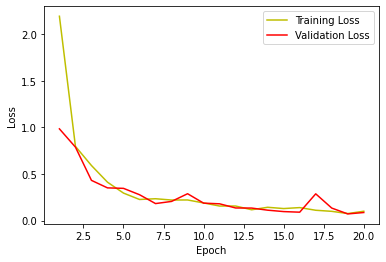

In [59]:
train_loss = history.history['loss']
validation_loss = history.history['val_loss']
epoch_count = range(1, len(train_loss) + 1)

plt.plot(epoch_count, train_loss, 'y', label="Training Loss")
plt.plot(epoch_count, validation_loss, 'r', label="Validation Loss")
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# File input
Model siap memprediksi file input berupa gambar. Di mana dapat memprediksi dengan sangat baik file input yang atributnya mirip dengan data train, seperti memiliki atribut background berwarna hijau.

Saving 6sInddznuGf5KuRo.png to 6sInddznuGf5KuRo.png
6sInddznuGf5KuRo.png
rock


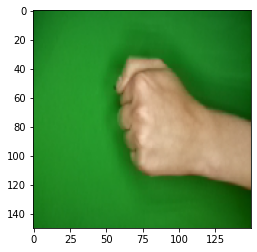

In [53]:
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  classes = np.argmax(classes)
  print(fn)
  if classes == 0:
    print('paper')
  elif classes == 1:
    print('rock')
  else:
    print('scissors')